In [1]:
# @title Data retrieval
import os, requests

fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

     |████████████████████████████████| 9.6 MB 5.0 MB/s 
     |████████████████████████████████| 13.3 MB 4.6 MB/s 
     |████████████████████████████████| 3.2 MB 33.8 MB/s 
     |████████████████████████████████| 86 kB 319 kB/s 
     |████████████████████████████████| 179 kB 31.2 MB/s 


In [3]:
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[1][1]

print(dat.keys())

dict_keys(['V', 't_off', 'locs', 'srate', 'scale_uv', 't_on', 'target', 'stim_id', 'response', 'rt', 'expinfo', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [4]:
def voltage_from_data(complete_dataset = alldat):

  # pick subject 1 and experiment 1
  dat = complete_dataset[1][1]
  V = dat['V'].astype('float32') # always convert the voltage data to float32!

  # high-pass filter above 50 Hz
  b, a = signal.butter(3, [50], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # compute smooth envelope of this signal = approx power
  V = np.abs(V)**2
  b, a = signal.butter(3, [10], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # normalize each channel so its mean power is 1
  V = V/V.mean(0)

  return V

---
# Dataset info

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 3 sessions from 3 subjects, and was not yet used in a publication, so it's fresh data for you to analyze! The following references using other datasets may be useful for the memory n-back task: 

- Brouwer, Anne-Marie, et al. "Estimating workload using EEG spectral power and ERPs in the n-back task." Journal of Neural Engineering 9.4 (2012): 045008. doi: [10.1088/1741-2560/9/4/045008](https://doi.org/10.1088/1741-2560/9/4/045008)

- Grissmann, Sebastian, et al. "Electroencephalography based analysis of working memory load and affective valence in an n-back task with emotional stimuli." Frontiers in Human Neuroscience 11 (2017): 616. doi: [10.3389/fnhum.2017.00616](https://doi.org/10.3389/fnhum.2017.00616)

Each subject's data is divided into 5 sessions: fixation, exp1, exp2, exp3, fixation, which are consecutive blocks in the data structure (i.e. `alldat[0][0]`, `alldat[0][1]`, ..., `alldat[0][4]` for subject 0). Exp1 is a "0-back" memory experiment, where the subjects have to identify the picture of one of the houses (stimid = 10), which they have memorized at the beginning of the stimulus block. Exp2 is a 1-back memory experiment, where the participants have to respond to images of repeated houses. Finally, exp3 is 2-back where participants respond to pictures of houses that are repeated after another intervening random picture. This task was hard for these participants and most of them did not really respond at all, but the data can still be used to ask questions about overall shifts of neural activity in a hard task when the subjects feel overwhelmed by the memory requirements.

Note that for the third/last subject, no response data was collected, so only the first two subjects can be analyzed for their correct / incorrect trials.   

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size. 

Variables for each block within each subject: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['expinfo']`: experiment type for this block
* `dat['srate']`: sampling rate for voltage data, always 1000Hz
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, usually 600 samples after `t_on`
* `dat['stim_id`]: identity of house stimulus from 1 to 40. Stimulus 10 was the target in the 0-back task.  
* `dat['target']`: 0 or 1, indicates if this stimulus requires a response
* `dat['response']`: 0 or 1, indicates if the subject actually made a response
* `dat['rt']`: reaction time for trials with a response in voltage data samples (1000Hz). 
* `dat['locs']`: 3D locations of the electrodes on the cortical surface

In [5]:
for key in dat.keys():
  if(type(dat[key]) == np.ndarray):
    print(key, " : ", dat[key].shape)
  elif (type(dat[key]) == list) :
    print(key, " : ", len(dat[key]))
  else : 
    print(key, " : ", dat[key])

V  :  (240160, 64)
t_off  :  (100,)
locs  :  (64, 3)
srate  :  1000
scale_uv  :  (64,)
t_on  :  (100,)
target  :  (100,)
stim_id  :  (100,)
response  :  (100,)
rt  :  (100,)
expinfo  :  0-back
hemisphere  :  64
lobe  :  64
gyrus  :  64
Brodmann_Area  :  64


## Data Pre-Processing

In [6]:
# compute spectral power above 50Hz and low-pass below 10Hz
# power is always positive, so we normalize it by its average
from scipy import signal

# pick subject 1 and experiment 1
dat = alldat[1][1]
V = dat['V'].astype('float32') # always convert the voltage data to float32!

# # high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# # compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [7]:
# divide into trials and average
nt, nchan = V.shape
nstim = len(dat['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-400, 1600)
ts = dat['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_resp = (V_epochs[dat['response'] == 1]).mean(0)
V_base = (V_epochs[dat['response'] == 0]).mean(0)

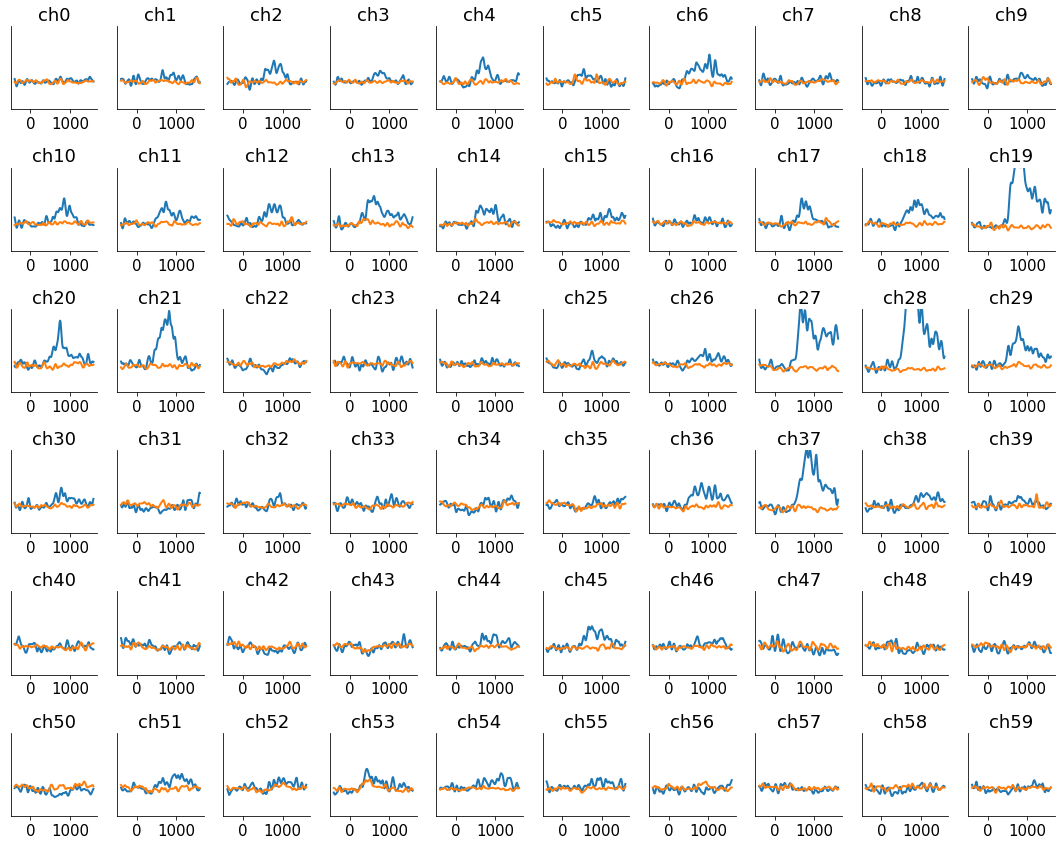

In [8]:
# let's find the electrodes that distinguish responses from non-responses
# note these are event-related potentials

plt.figure(figsize=(15, 12))
for j in range(60):
  ax = plt.subplot(6, 10, j+1)
  plt.plot(trange, V_resp[:, j], lw=2)
  plt.plot(trange, V_base[:, j], lw=2)
  plt.title('ch%d'%j)
  plt.yticks([])
  plt.ylim([0, 3])
plt.show()

### DataFrame

In [9]:
pd.DataFrame(dat)

ValueError: ignored

## Data Exploration

### Correlation Matrix

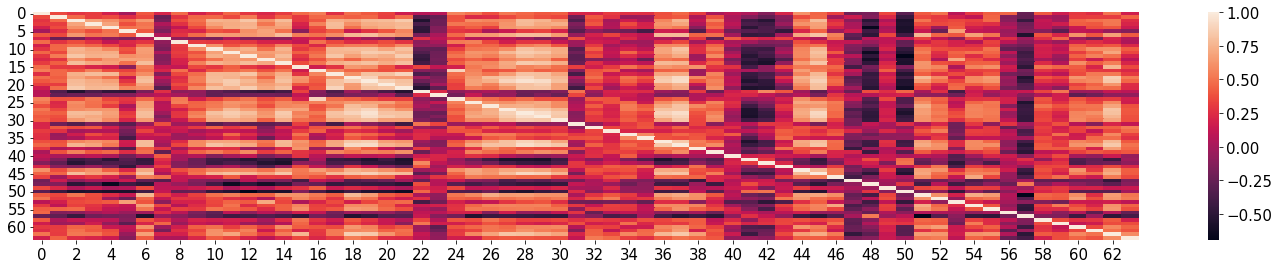

In [10]:
# V_resp

resp_corr = np.corrcoef(V_resp.T)
base_corr = np.corrcoef(V_base)

sns.heatmap(resp_corr, annot= False)
plt.show()

### Clustering

### K-Means

In [11]:
from sklearn.cluster import KMeans

In [12]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

NameError: ignored

## PCA

In [13]:
#@title
# Utility Functions

def get_variance_explained(evals):
  # Cumulatively sum the eigenvalues
  csum = np.cumsum(evals)

  # Normalize by the sum of eigenvalues
  variance_explained = csum/np.sum(evals)

  return variance_explained

def plot_variance_explained(variance_explained, axis = False):

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Cummulated Number of P_components from channels')
  plt.ylabel('Variance explained')
  if axis : 
    plt.ylim([0, 1])
  plt.show()

def sort_evals_descending(evals, evectors):

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors

In [14]:
def pca(X):
  
  X_mean = X - np.mean(X, 0)
  X_COV = np.cov(X_mean.T)

  evals, evectors = np.linalg.eigh(X_COV)

  evals, evectors = sort_evals_descending(evals, evectors)

  score = V_resp @ evectors

  # Calculate the variance explained
  variance_explained = get_variance_explained(evals)

  return variance_explained, score, evals, evectors

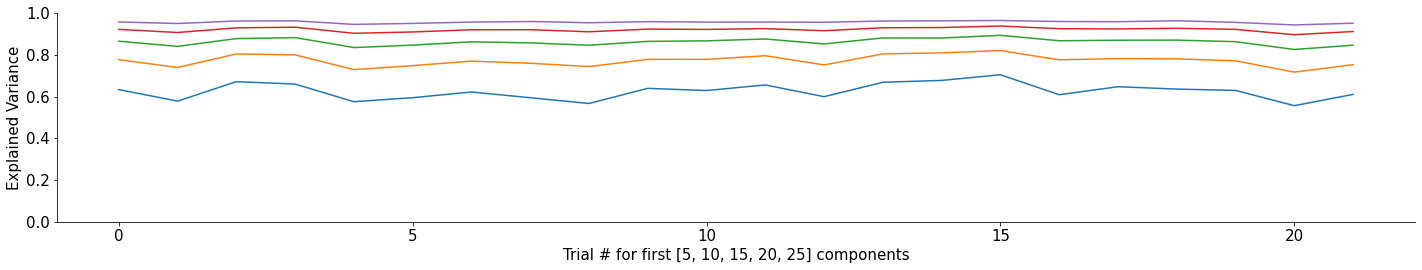

In [15]:
res = []
cum_comp_num = [5, 10, 15, 20, 25]

# divide into trials and average
nt, nchan = V.shape
nstim = len(dat['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset

trange = np.arange(-400, 1600)
ts = dat['t_on'][:, np.newaxis] + trange

V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_resp = (V_epochs[dat['response'] == 1])
V_base = (V_epochs[dat['response'] == 0])

for cum_comp_num_value in cum_comp_num : 
  for V_resp_trial in V_resp:

    ans, _, _, _ = pca(V_resp_trial)

    res.append(ans[cum_comp_num_value])

  plt.plot(res)
  plt.xlabel("Trial # for first " + str(cum_comp_num) + " components")
  plt.ylabel("Explained Variance")
  plt.ylim([0, 1])
  res = []
plt.show()

In [16]:
pca_components, pca_score, evals, evectors = pca(V_resp)

def plot_PCA_weights(weights):
  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(weights), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()

plot_PCA_weights(np.reshape(evectors[:, 0], (8,8)))

ValueError: ignored

In [ ]:
plot_PCA_weights(evectors)

In [ ]:
norm_evals = evals / evals.sum()
norm_evals.shape

In [ ]:
norm_evals_matrix = np.reshape(np.repeat(norm_evals, len(norm_evals)), (64, 64))

In [ ]:
plot_PCA_weights(np.reshape(np.sum(evectors * norm_evals_matrix.T, axis = 1), (8,8)))

### HDBSCAN



## Hierarchical Clustering

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

SUBJECT  0  --------
Experiment 1
[[77  1]
 [ 0 22]] 100
FPR, FNR : 0.013  0.000
Experiment 2
[[79  1]
 [ 2 18]] 100
FPR, FNR : 0.013  0.100
Experiment 3
[[78  2]
 [13  7]] 100
FPR, FNR : 0.025  0.650
SUBJECT  1  --------
Experiment 1
[[77  1]
 [ 1 21]] 100
FPR, FNR : 0.013  0.045
Experiment 2
[[80  0]
 [ 5 15]] 100
FPR, FNR : 0.000  0.250
Experiment 3
[[80  0]
 [18  2]] 100
FPR, FNR : 0.000  0.900
SUBJECT  2  --------
Experiment 1
[[78  0]
 [22  0]] 100
FPR, FNR : 0.000  1.000
Experiment 2
[[80  0]
 [20  0]] 100
FPR, FNR : 0.000  1.000
Experiment 3
[[80  0]
 [20  0]] 100
FPR, FNR : 0.000  1.000


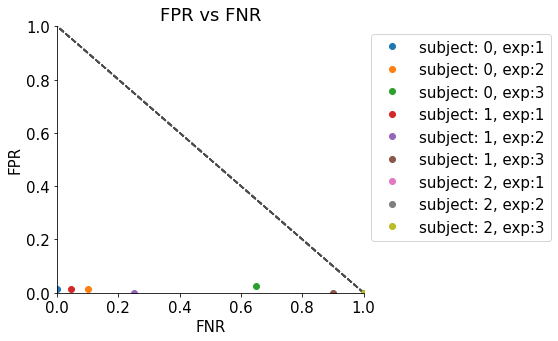

In [ ]:
for subject in range(3):
  print("SUBJECT ", subject, " --------")
  for exp in range(1, 4):
    print("Experiment", exp)

    data = alldat[subject][exp]
    data_target = data['target']
    data_res = data['response']
    cnf_m = confusion_matrix(data_target, data_res)
    print(cnf_m, np.sum(cnf_m))
    
    FPR =  cnf_m[0][1]/ (cnf_m[0][0] + cnf_m[0][1])   # False positive ratio : FPR = FP/(FP+TN)
    FNR = cnf_m[1][0]/ (cnf_m[1][0] + cnf_m[1][1])    # False negative ratio : FNR = FN/(FN+TP)
    print(f"FPR, FNR : {FPR:.3f} {FNR: .3f}")

    plt.rcParams["figure.figsize"] = [8.00, 5.00]
    
    plt.title('FPR vs FNR')
    plt.xlabel('FNR')
    plt.ylabel('FPR')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.plot([1, 0], [0, 1], ls="--", c=".3")
   
    plt.plot(FNR,FPR,'o',label="subject: "+str(subject)+", exp: "+str(exp))
    plt.legend(bbox_to_anchor=(1.0, 1.0),loc='upper left')

    # the count of true negatives is C00 , false negatives is C10, true positives is C11  and false positives is C01 .